<a href="https://colab.research.google.com/github/emmanuelkyeremeh/Conceptually/blob/master/deviation_from_mean_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/QFHD'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1zgbI4HtAh4L5VsbEGVeF9fSUylAVhvLx/QFHD


In [2]:
!pip install catboost

In [4]:
!pip install tsai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x8

In [3]:
!pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.2 MB/s eta 0:00:00


In [5]:
!pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=a28129a1c7fec6cb336976e655b55f9a5b0bd0fc0f5594d50dc10b7536ba395d
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


## Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import re
import emd
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from qf_plus_shared.src.signal_processing import *
from qf_plus_development.src.utilities import get_meta_data
from catboost import CatBoostRegressor, Pool
import sys
sys.path.append('/content/drive/MyDrive/QFHD/qf_plus_development/qfhd/src')
from qf_plus_development.qfhd.src.preprocessing import preprocess_data

# Data

In [5]:
meta_data_file = get_meta_data('/content/drive/MyDrive/QFHD/metadata3.xlsx')

In [6]:
pickle_file   = '/content/drive/MyDrive/QFHD/data/preprocessed_24Jan22_134624.p'

pickle_data = pd.read_pickle(pickle_file)

loaded_data = pickle_data

filenames = list(loaded_data['file_data'])
filenames.sort()

# Feature Extraction

## Create `cycles_dict`

In [ ]:
def find_closest(my_list):
    """
    This function finds the number within the 2nd and the last element
    which is closest in value to the 1st element in the list.

    Args:
        my_list: A list of integers.

    Returns:
        The integer within the 2nd and the last element which is closest
        in value to the 1st element in the list, or None if the list has less than 3 elements.
    """
    if len(my_list) < 3:
      return None  # Not enough elements in the list

    first_element = my_list[0]
    potential_second = my_list[1]
    potential_last = my_list[-1]
    distance_second = abs(first_element - potential_second)
    distance_last = abs(first_element - potential_last)

    # Check the rest of the elements between 2nd and last positions
    for i in range(2, len(my_list) - 1):
      current_distance = abs(first_element - my_list[i])
      if current_distance < distance_second:
        distance_second = current_distance
        potential_second = my_list[i]
      if current_distance < distance_last:
        distance_last = current_distance
        potential_last = my_list[i]

    # Return the closest element based on the minimum distance
    if distance_second <= distance_last:
      return potential_second
    else:
      return potential_last

In [ ]:
cycles_dict = {}
for filename in filenames:

  cycles_dict[filename] = {
        'cycles': None,
        'peaks': None,
        'troughs': None
    }

  df = loaded_data['file_data'][filename]['cycle']
  ppg_ = df.to_numpy()
  ppg = df.to_numpy()
  time = df.index.to_numpy()

  # Run a mask sift
  imf = emd.sift.mask_sift(ppg_)

  # ***
  # add actual signal to imf variable
  ppg = ppg.reshape(-1, 1)
  imf = np.hstack((ppg, imf))

  # Find number of cycles for actual signal and all IMFs
  IP, IF, IA = emd.spectra.frequency_transform(imf, len(time), 'nht')
  all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)

  category = []
  values   = []
  for i in range(imf.shape[1]):
    ctrl   = emd.cycles.get_control_points(imf[:, i], all_cycles[:, i])
    cycles = len(ctrl)
    category.append(f'IMF-{i}')
    values.append(cycles)

  # *** best IMF based on number of cycles in raw signal
  x   = find_closest(values)
  idx = values[1:].index(x)


  # Sum the first 3 IMFS if the best IMF is one of the first 3 IMFs, otherwise sum the first N IMFs. the N is the best IMF eg. if IMF 5 was
  # selected as the best IMF then we sum the first 5 IMFs, if IMF 6 was selected then we sum the first 6 IMFs and so on
  if idx < 3: #if the best IMF is one of the first 3, the sum the first 3 IMFs
    imf_3_sum = imf[:, 1:4].sum(axis=1)
    imf_3_sum = imf_3_sum.reshape(-1, 1)
    imf       = np.delete(imf, np.s_[1:4], axis=1) # delete 1st 3 imfs
    all_cycles= np.delete(all_cycles, np.s_[1:4], axis=1) # delete 1st 3 all_cycles
    # imf       = np.delete(imf, np.s_[0], axis=1) # delete ppg from imf var
    imf       = np.hstack((imf_3_sum, imf))
  else:
    # Sum the first N IMFs
    imf_N_sum = imf[:, 1:idx + 2].sum(axis=1) #check
    imf_N_sum = imf_N_sum.reshape(-1, 1)
    imf       = np.delete(imf, np.s_[1:idx + 2], axis=1) # delete 1st 4 or more ims #check
    all_cycles= np.delete(all_cycles, np.s_[1:idx + 2], axis=1) # delete 1st 4 or more all_cycles
    # imf       = np.delete(imf, np.s_[0], axis=1) # delete ppg from imf var
    imf       = np.hstack((imf_N_sum, imf))

  # ***

  # Find number of cycles for actual signal and all IMFs
  IP_, IF_, IA_ = emd.spectra.frequency_transform(imf, len(time), 'nht')
  all_cycles_ = emd.cycles.get_cycle_vector(IP_, return_good=False)

  all_cycles  = np.hstack((all_cycles_[:, 0].reshape(-1, 1), all_cycles))

  category = []
  values   = []
  for i in range(imf.shape[1]):
    ctrl   = emd.cycles.get_control_points(imf[:, i], all_cycles[:, i])
    cycles = len(ctrl)
    category.append(f'IMF-{i}')
    values.append(cycles)

  values[0], values[1] = values[1], values[0]


  # ***

  # best IMF based on number of cycles in raw signal
  x   = find_closest(values)
  idx = values[1:].index(x)

  # ***

  imf       = np.delete(imf, np.s_[1], axis=1) # delete ppg from imf var


  ctrl = emd.cycles.get_control_points(imf[:, 0], all_cycles[:, 0])

  # Define some marker styles and legend labels for the control points.
  markers = ['og', '^b', 'oc', 'vb', 'or']
  label   = ['Asc-Start', 'Peak', 'Desc', 'Trough', 'Asc-End']

  # Plot the first 10 cycles with control points
  ncycles = len(ctrl)
  start   = 0

  cycles, peaks, troughs = [], [], []
  for ii in range(ncycles):
      # print('Cycle {0:2d} - {1}'.format(ii, ctrl[ii, :]))
      cycle = imf[all_cycles[:, 0] == ii, 0]
      # plt.plot(np.arange(len(cycle))+start, cycle, 'k', label='Cycle')         Uncomment lines 148 for plots
      # plt.plot(time[start:len(cycle)], cycle, 'k', label='Cycle')
      for jj in range(5):
          if np.isfinite(ctrl[ii, jj]):
              # plt.plot(ctrl[ii, jj]+start, cycle[int(ctrl[ii, jj])], markers[jj], label=label[jj])      Uncomment lines 152 for plots
              if jj == 1:
                peaks.append(ctrl[ii, jj])
              if jj == 3:
                troughs.append(ctrl[ii, jj])
      cycles.append(cycle)
      # Updates the starting position for the next cycle
      start += len(cycle)



  # store cycles data in dictionary
  cycles_dict[filename]['cycles']  = cycles
  cycles_dict[filename]['peaks']   = peaks
  cycles_dict[filename]['troughs'] = troughs



## Find Deviation and Create Features

In [ ]:
# Function to combine cycles for each subject ID
def combine_cycles(subject_id, cycles_dict):
    combined_cycles = []
    N = 200
    for signal_id, data in cycles_dict.items():
        if signal_id.startswith(subject_id):

          # Initialize an empty list for the processed cycles
          processed_cycles = []

          # Loop over the input cycles
          for cycle in data['cycles']:
              # Create an interpolation function based on the original cycle
              cycle = resample_interp_nb(cycle, N)

              # normalize each cycle separately (optional)
              mean_value = cycle.mean()
              scaling_factor = cycle.max() - cycle.min()
              if scaling_factor == 0:
                    cycle = np.zeros_like(cycle)
              else:
                  cycle = (cycle - mean_value) / scaling_factor * 100

              # Append the processed cycle to the output list
              processed_cycles.append(cycle)
          combined_cycles.extend(processed_cycles)
    return combined_cycles

# Function to calculate mean cycle
def calculate_mean_cycle(cycles):
    return np.mean(cycles, axis=0)

# Function to calculate deviations from mean cycle
def calculate_deviations(cycles, mean_cycle):
    return cycles - mean_cycle

# Function to create features from deviations
def create_features(deviations):
    features = {
        'mean_deviation': np.mean(deviations),
        'std_deviation': np.std(deviations),
        'max_deviation': np.max(deviations),
        'min_deviation': np.min(deviations)
    }
    return features

## Prepare Data for Model Training

In [ ]:
meta_data_file = meta_data_file[(meta_data_file['Use_4_Train']) & (meta_data_file['Strain'].notna())]

In [ ]:
# Process each subject ID
subject_ids = list(meta_data_file['Subject_ID'].unique())
all_features = []
for id in subject_ids:
    combined_cycles = combine_cycles(id, cycles_dict)

    if len(combined_cycles) > 0:
        mean_cycle = calculate_mean_cycle(combined_cycles)
        deviations = calculate_deviations(combined_cycles, mean_cycle)
        features = create_features(deviations)
        features['Subject_ID'] = id
        all_features.append(features)

# Combine all features into a single DataFrame
features_df = pd.DataFrame(all_features).merge(meta_data_file, on='Subject_ID')

features_df = features_df.drop(columns=['Use_4_Train','Clinic'])

columns_to_encode = ['IsMale', 'Hx_HTN', 'HxCVD','DM','HxSmoke','HxStroke','HxCOPD']
df = features_df[columns_to_encode]

encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(df)

df_encoded = encoder.transform(df).toarray()

column_names = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(df_encoded, columns=column_names)

features_df = pd.concat([features_df, encoded_df], axis=1)

features_df = features_df.drop(columns=columns_to_encode)

target  = features_df['Strain']

features_df = features_df.drop(columns=['Subject_ID', 'Strain','LVEF'])
features_df.head()

,mean_deviation,std_deviation,max_deviation,min_deviation,Age,IsMale_False,IsMale_True,Hx_HTN_False,HxCVD_False,HxCVD_True,DM_False,DM_True,HxSmoke_False,HxSmoke_True,HxStroke_False,HxStroke_True,HxCOPD_False,HxCOPD_True
0,-4.263256e-16,7.898624,106.711628,-70.040912,76.733333,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,-7.097746e-16,9.916737,92.040929,-78.158063,69.366667,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,-7.884292e-16,9.081062,95.463616,-88.217467,75.800000,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.768171e-16,8.778049,63.639400,-99.176335,46.463889,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,3.805619e-16,10.339564,56.060437,-57.954732,62.625000,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Train Model and Evaluate Performance

In [ ]:
# Prepare feature matrix (X) and target variable (y)
X = features_df
y = target

# Split the data into training+validation and test sets (e.g., 80% train+validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets (e.g., 75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Define the parameter grid for CatBoost
param_grid = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100]
}

# Initialize the CatBoost Regressor
catboost_model = CatBoostRegressor(silent=True)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='neg_mean_absolute_error',  # Objective function
    cv=3,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best MAE: {-random_search.best_score_}")

# Train the model with the best parameters on the full training data
best_params = random_search.best_params_
model = CatBoostRegressor(**best_params, silent=True)
model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 7, 'border_count': 100}
Best MAE: 2.77766147230021


MAE for predictions on training dataset 0.006988987190125176
MAE for predictions on validation dataset 2.8406647411490726
MAE for predictions on testing 3.0330642884652


(3.0, 25.0, 3.057180136244788, 23.92755705574474)

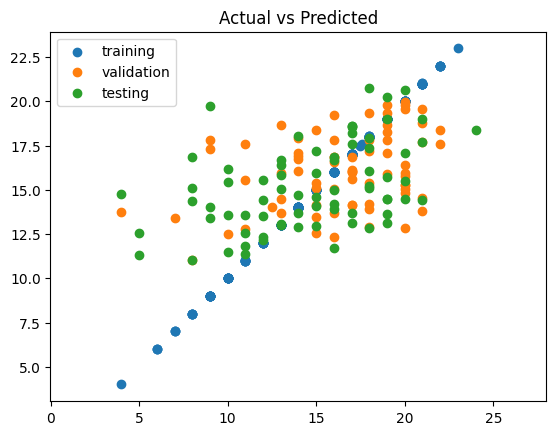

In [ ]:
y_pred = model.predict(X_train)
plt.scatter(y_train, y_pred, label="training")
mae = mean_absolute_error(y_pred, y_train)
print(f"MAE for predictions on training dataset {mae}" )

y_pred = model.predict(X_val)
plt.scatter(y_val, y_pred, label="validation")
mae = mean_absolute_error(y_pred , y_val)
print(f"MAE for predictions on validation dataset {mae}")

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, label="testing")
mae = mean_absolute_error(y_pred , y_test)


print(f"MAE for predictions on testing {mae}")
plt.title("Actual vs Predicted")
plt.legend()
plt.axis('equal')

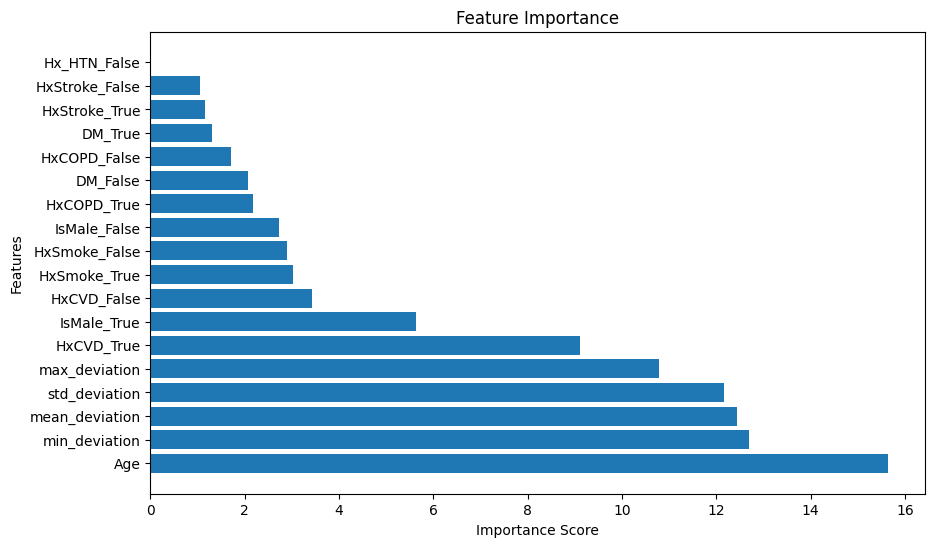

In [ ]:
feature_importances = model.get_feature_importance(Pool(X_train, y_train))

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Create a barplot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(feature_importances)), np.array(X_train.columns)[sorted_indices], rotation=0)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()